# Perceptron 
https://en.wikipedia.org/wiki/Perceptron

In [9]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
from sklearn import datasets
import copy
import cv2

In [10]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

### Simple perceptron

In [11]:
def accuracy(true_labels, predicted_labels):
    cnt = 0
    for i in range(0, len(true_labels)):
        if true_labels[i] != predicted_labels[i]:
            cnt += 1
    return 1 - cnt / len(true_labels)

In [12]:
class Perceptron:
    def __init__(self, iterations=100, etha=0.1):
        self.w = None
        self.iters_count = iterations
        self.etha = etha
        
    def activation_function(self, x):
        return 1 if np.dot(self.w, x) > 0 else 0
    
    def fit(self, X, y):
        self.w = np.random.uniform(low=0, high=0.1, size=(X.shape[1] + 1))
        new_X = np.ones((X.shape[0],X.shape[1]+1))
        new_X[:, 1:] = X
                
        sample_size = len(y)
        cnt = 0
        while cnt < self.iters_count:
            for i in range(0, sample_size):
                pred = self.activation_function(new_X[i])
                if pred != y[i]:
                    if y[i] == 0:
                        self.w = self.w + self.etha * (-1) * new_X[i]
                    else:
                        self.w = self.w + self.etha * new_X[i]
            cnt += 1
                
    def predict(self, X):
        pred = []
        new_X = np.ones((X.shape[0],X.shape[1]+1))
        new_X[:, 1:] = X
        for x in new_X:
            pred.append(self.activation_function(x))
        return pred

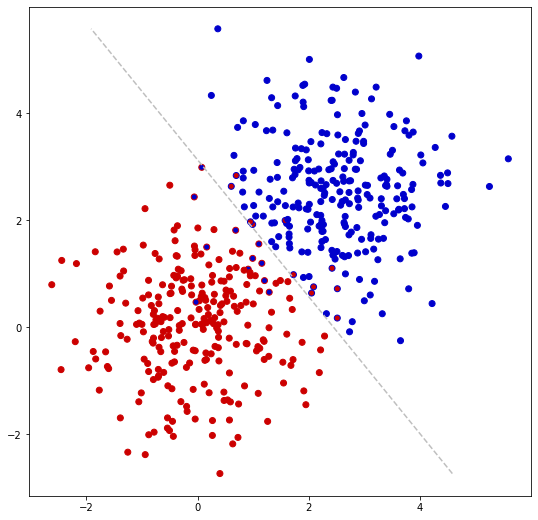

In [13]:
X, true_labels = make_blobs(500, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron(300)
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

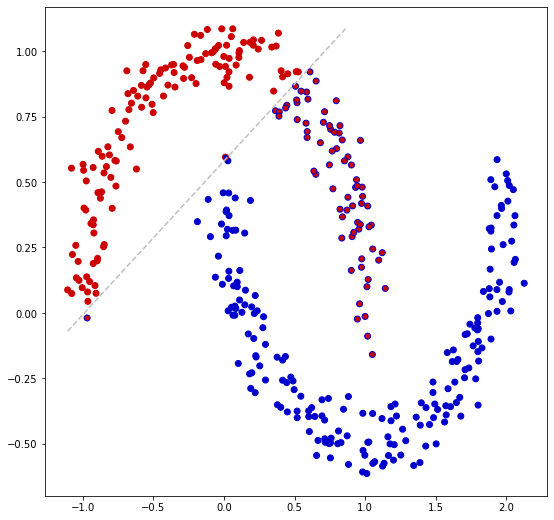

In [14]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Perceptron with best result

In [15]:
class PerceptronBest:
    def __init__(self, iterations=100):
        self.w = None
        self.iters_count = iterations
        self.etha = 0.1
        
    def accuracy(self, true_labels, predicted_labels):
        cnt = 0
        for i in range(0, len(true_labels)):
            if true_labels[i] == predicted_labels[i]:
                cnt += 1
        return cnt / len(true_labels)
        
    def activation_function(self, x):
        return 1 if np.dot(self.w, x) > 0 else 0
    
    def fit(self, X, y):
        self.w = np.random.uniform(low=0, high=1, size=(X.shape[1] + 1))
        new_X = np.ones((X.shape[0],X.shape[1]+1))
        new_X[:, 1:] = X
        
        w_best = None
        max_accuracy = 0
        sample_size = len(y)
        cnt = 0
        while cnt < self.iters_count:
            for i in range(0, sample_size):
                pred = self.activation_function(new_X[i])
                if pred != y[i]:
                    if y[i] == 0:
                        self.w = self.w + self.etha * (-1) * new_X[i]
                    else:
                        self.w = self.w + self.etha * new_X[i]
                    
            curr_accuracy = self.accuracy(y, self.predict(X))
            if curr_accuracy > max_accuracy:
                max_accuracy = curr_accuracy
                w_best = self.w

            cnt += 1
        self.w = w_best
                
    def predict(self, X):
        pred = []
        new_X = np.ones((X.shape[0],X.shape[1]+1))
        new_X[:, 1:] = X
        for x in new_X:
            pred.append(self.activation_function(x))
        return pred

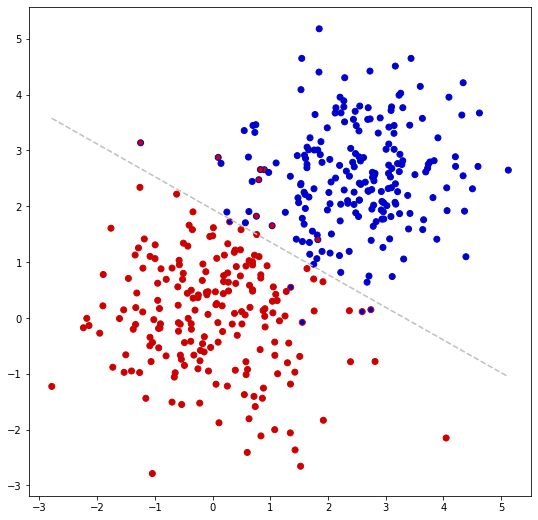

In [16]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest(150)
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

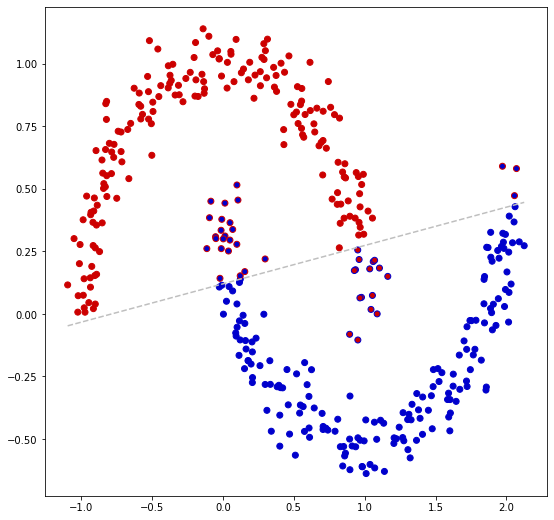

In [17]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest(150)
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### digits analysis

In [18]:
def symmetry(image):
    tr = np.transpose(image)
    delta = 0
    for i in range(0, 4):
        delta += np.sum(tr[3 - i] - tr[4 + i]) / 8
    
    return delta

In [19]:
def intensity(image):
    i = 0
    ver = []
    tr = np.transpose(image)
    for i in range(0, 8):
        ver.append(np.sum(tr[i]))
  
    return np.max(ver)

In [20]:
def transform_images(images):
    new_images = []
    for image in images:
        new_images.append([symmetry(image), intensity(image)])
    return np.array(new_images)

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

### MNIST test

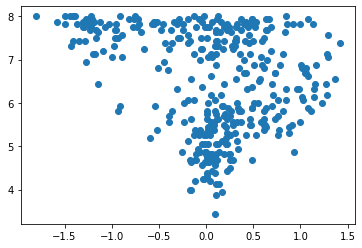

In [21]:
X, y = get_digits()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
matplotlib.pyplot.scatter(np.transpose(X)[0], np.transpose(X)[1])

In [22]:
for i in range(0, len(y_train)):
    if y_train[i] == 5:
        y_train[i] = 1
    elif y_train[i] == 1:
        y_train[i] = 0
        
for i in range(0, len(y_test)):
    if y_test[i] == 5:
        y_test[i] = 1
    elif y_train[i] == 1:
        y_test[i] = 0

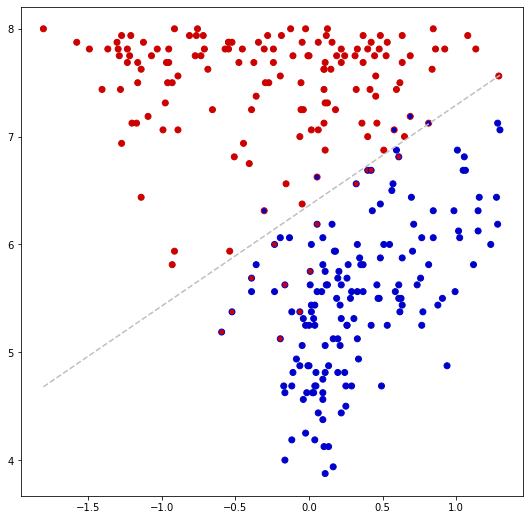

Accuracy: 0.8082191780821918


In [25]:
c = Perceptron(iterations=1000, etha=0.05)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

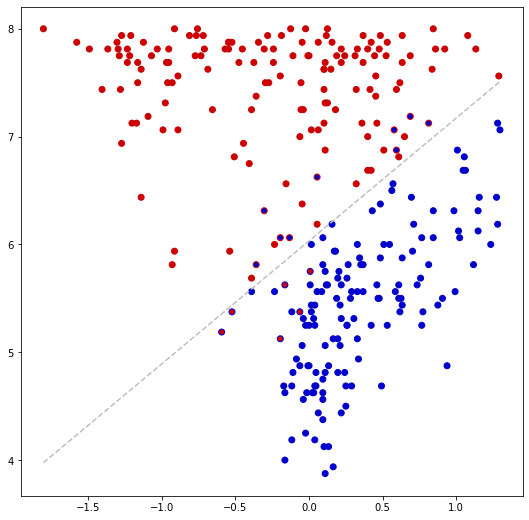

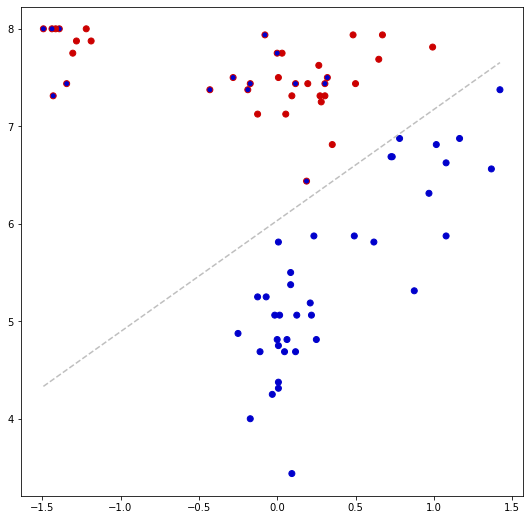

Accuracy: 0.7945205479452054


In [16]:
c = PerceptronBest(iterations=5000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
visualize(X_test, y_test, np.array(c.predict(X_test)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))